In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization
from dftpy.interface import GetForces
from ase.build import bulk
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/home/vr371/.local/lib/python3.8/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


#### Porpose of this code
Evaluate the energy of the system using OFDFT with the $\rho_{0}$'s foun in the code named rho0_dT.
In this code we won't use the KS electron density, we will p

In [2]:
path_pp='/home/vr371/PP/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [3]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/home/vr371/cWT-KEDF/Phases/DATA/Si_Btin/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_te = str(k).split()[6]
    KS_TE.append(float(KS_te)) 

In [4]:
# with open('.../Si-B-tin/DATA2/rho0.pkl','rb') as f:
#     rho00 = pickle.load(f)
rho00 = np.load('/home/vr371/cWT-KEDF/Phases/DATA/Si_Btin/DATA2/rho0.npy')
KS_KE = []
for i in np.arange(0,30,1):
    with open('/home/vr371/cWT-KEDF/Phases/DATA/Si_Btin/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Kinetic energy" in match]
    KS_ke = str(k).split()[6]
    KS_KE.append(float(KS_ke)) 
ks_ke = np.asarray(KS_KE)

In [10]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
ENERGY = []
VOLUME = []
for n in np.arange(0, 30, 1):
        i = int(n)
        
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)

        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()

        ENERGY.append(energy)
        VOLUME.append(vol)

setting key: Si -> /.../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.810500545993E+00      9.810501E+00    4.864010E+00    1       1       4.714489E-02    
1       8.809912923205E+00      -1.000588E+00   2.772557E-01    4       2       1.304250E-01    
2       8.792713432132E+00      -1.719949E-02   2.038253E-02    4       1       1.649461E-01    
3       8.790314061984E+00      -2.399370E-03   1.270926E-03    6       1       2.129261E-01    
4       8.790243845832E+00      -7.021615E-05   8.532779E-05    4       1       2.747324E-01    
5       8.790235305658E+00      -8.540174E-06   8.453334E-06    5       1       3.252017E-01    
6       8.790234552861E+00      -7.527970E-07   6.745703E-07    6       1       3.812764E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.7720003436035632
Chemical potential (eV)  : 21.007197356275675
setting key: Si -> /...

2       1.212357176723E+00      -1.933407E-02   2.214443E-02    4       1       2.896850E-01    
3       1.209061732951E+00      -3.295444E-03   9.642118E-04    8       1       3.818221E-01    
4       1.208959772383E+00      -1.019606E-04   5.813204E-05    5       1       4.902780E-01    
5       1.208952120624E+00      -7.651758E-06   3.881640E-06    7       1       5.781491E-01    
6       1.208951662779E+00      -4.578454E-07   2.277602E-07    6       1       6.661413E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18244838397737273
Chemical potential (eV)  : 4.964672932211042
setting key: Si -> /.../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.273920846138E+00      2.273921E+00    2.332492E+00    1       1       2.910399E-02    
1       9.469751996566E-01      -1.326946E+00   3.534134E-01    12      2       2.648919E-01    
2       9.211249023182E

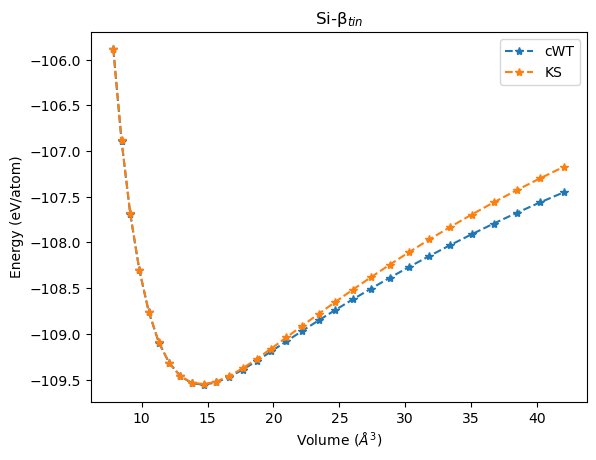

In [11]:
plt.plot(np.asarray(VOLUME)*0.529177**3/4,(np.asarray(ENERGY))*27.211407/4,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(KS_TE)*27.211407/8,'*--')
plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-\u03B2$_{tin}$')
plt.legend(['cWT','KS'])

In [13]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

Forces = []
for n in np.arange(0, 30, 1):
        i = int(n)      
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)
        move_atom = ions[1]
        move_atom.position[:] += 0.1
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)    
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        forces = GetForces(ions, rho, evaluator)
        Forces.append(forces)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.810500545993E+00      9.810501E+00    4.888958E+00    1       1       6.280422E-03    
1       8.800769222166E+00      -1.009731E+00   2.703988E-01    4       2       2.476573E-02    
2       8.783704037319E+00      -1.706518E-02   2.011278E-02    4       1       3.833604E-02    
3       8.781353593213E+00      -2.350444E-03   1.248212E-03    6       1       5.617738E-02    
4       8.781283717452E+00      -6.987576E-05   9.700691E-05    4       1       6.941104E-02    
5       8.781274272810E+00      -9.444643E-06   8.397780E-06    5       1       8.457470E-02    
6       8.781273450319E+00      -8.224909E-07   8.067118E-07    6       1       1.022177E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.7719227608382522
Chemical potential (eV)  : 21.0050862219014
setting key: Si -> /home/vr371

3       4.070944241796E+00      -1.105233E-03   4.010014E-04    6       1       7.302403E-02    
4       4.070889830328E+00      -5.441147E-05   3.476327E-05    7       1       9.760666E-02    
5       4.070886698667E+00      -3.131661E-06   2.230335E-06    6       1       1.187289E-01    
6       4.070886304134E+00      -3.945322E-07   1.272653E-07    8       1       1.447251E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3951304256220914
Chemical potential (eV)  : 10.752045515636437
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.556389029367E+00      4.556389E+00    2.816955E+00    1       1       7.707596E-03    
1       3.658451768132E+00      -8.979373E-01   1.951956E-01    7       2       4.116821E-02    
2       3.646654418300E+00      -1.179735E-02   1.320722E-02    4       1       5.894089E-02    
3       3.645406517687E+00  

Chemical potential (a.u.): 0.182412969535139
Chemical potential (eV)  : 4.963709256244534
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.273920846138E+00      2.273921E+00    2.341833E+00    1       1       7.979393E-03    
1       9.430959869799E-01      -1.330825E+00   3.712565E-01    12      2       6.630087E-02    
2       9.154781881696E-01      -2.761780E-02   2.308014E-02    5       1       9.212303E-02    
3       9.115961076977E-01      -3.882080E-03   1.727697E-03    8       1       1.287682E-01    
4       9.114831722597E-01      -1.129354E-04   1.506821E-04    4       1       1.494040E-01    
5       9.114666456434E-01      -1.652662E-05   8.799016E-06    6       1       1.782122E-01    
6       9.114648717920E-01      -1.773851E-06   6.136269E-07    9       1       2.180042E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.1

Chemical potential (eV)  : 1.375830633933185
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.949408264520E-01      9.949408E-01    2.180299E+00    1       1       1.017880E-02    
1       -9.351061778169E-01     -1.930047E+00   1.619617E+00    14      2       9.758806E-02    
2       -1.041566209209E+00     -1.064600E-01   1.467507E-01    4       1       1.265786E-01    
3       -1.073477884237E+00     -3.191168E-02   7.584105E-03    12      2       2.028522E-01    
4       -1.074105352689E+00     -6.274685E-04   4.393045E-04    5       1       2.371495E-01    
5       -1.074150649734E+00     -4.529704E-05   3.112321E-05    7       1       2.815990E-01    
6       -1.074154938080E+00     -4.288347E-06   2.174913E-06    8       1       3.315401E-01    
7       -1.074155327288E+00     -3.892080E-07   1.736681E-07    10      1       3.923767E-01    
#### Density Optimi

In [14]:
FORCE = []
FORCE_x = []
FORCE_y = []
FORCE_z = []
for i in np.arange(0,30,1):
    FORCE.append(np.linalg.norm(Forces[i]['TOTAL'][1]))
    FORCE_x.append((Forces[i]['TOTAL'][1,0]))
    FORCE_z.append((Forces[i]['TOTAL'][1,1]))
    FORCE_y.append((Forces[i]['TOTAL'][1,2]))

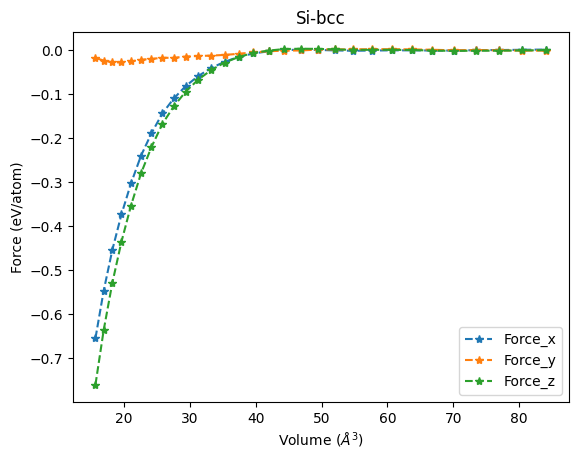

In [15]:
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_x))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_y))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_z))*27.211407/2,'*--')

plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Force (eV/atom)')
plt.title('Si-bcc')
plt.legend(['Force_x','Force_y', 'Force_z'])

In [17]:
np.save('/home/vr371/cWT-KEDF/Phases/DATA/Si_Btin/DATA2/Force.npy', Forces)

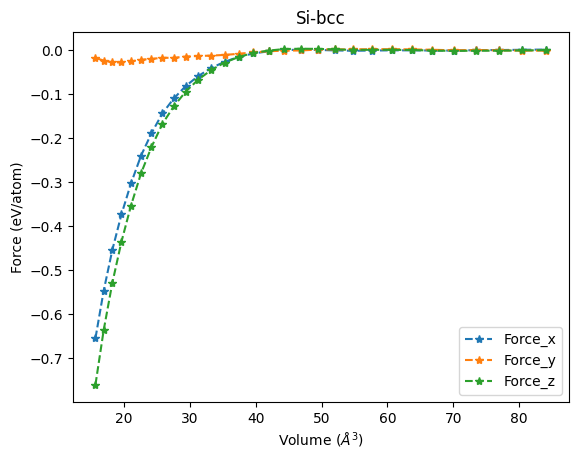

In [7]:
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_x))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_y))*27.211407/2,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/2,(np.asarray(FORCE_z))*27.211407/2,'*--')

plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Force (eV/atom)')
plt.title('Si-bcc')
plt.legend(['Force_x','Force_y', 'Force_z'])